In [ ]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, model_from_json

In [22]:
# load json and create model

json_file = open('/content/drive/My Drive/Colab Notebooks/SC/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [23]:
# load weights into new model

model.load_weights("/content/drive/My Drive/Colab Notebooks/SC/model.h5")

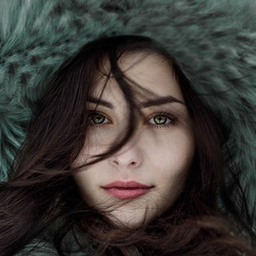

In [ ]:
# original image
load_img('/content/27gIpN.jpg')

In [40]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
# load the image with the required shape
img = load_img('/content/27gIpN.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
img /= 255.0
img = rgb2lab(1.0/255*img)[:,:,:,0]
img = img.reshape(img.shape+(1,))
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
pyplot.figure(figsize = (50, 50))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Output hidden; open in https://colab.research.google.com to view.

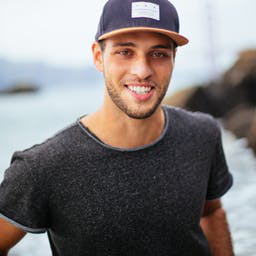

In [ ]:
load_img('/content/9R-CH7PR150.jpg')

In [38]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
# load the image with the required shape
img = load_img('/content/9R-CH7PR150.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
img /= 255.0
img = rgb2lab(1.0/255*img)[:,:,:,0]
img = img.reshape(img.shape+(1,))
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
pyplot.figure(figsize = (50, 50))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Output hidden; open in https://colab.research.google.com to view.

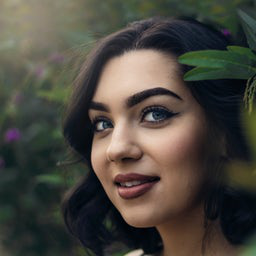

In [35]:
load_img('/content/1odYRPS_26o.jpg')

In [37]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
# load the image with the required shape
img = load_img('/content/1odYRPS_26o.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
img /= 255.0
img = rgb2lab(1.0/255*img)[:,:,:,0]
img = img.reshape(img.shape+(1,))
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
pyplot.figure(figsize = (50, 50))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Output hidden; open in https://colab.research.google.com to view.